In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=0)

In [5]:
'''
second performance test
'''
%time
import sys
sys.path.append('..')
%matplotlib inline
# you might need this:
#import matplotlib
#matplotlib.use('Agg')

from eden.converter.graph.gspan import gspan_to_eden
from graphlearn.graphlearn import GraphLearnSampler
import itertools
from eden.graph import Vectorizer
import matplotlib.pyplot as plt
import numpy as np

from eden.util import fit_estimator,fit , random_bipartition_iter,estimate
import random
from eden.util import selection_iterator as picker
from sklearn.linear_model import SGDClassifier

vectorizer = Vectorizer( complexity=2 )
#2401 positives and 1936 negatives
NUMPOS=2401
NUMNEG=1936

######################## testing ##############################
from eden.util import iterator_size 
from time import time
def train_estimator_and_evaluate_testsets(pos_original,neg_original,pos_augmented,neg_augmented,pos_test,neg_test):
    # create graph sets...orig augmented and sampled
    pos_orig,pos_orig_ = itertools.tee(pos_original)
    neg_orig,neg_orig_ = itertools.tee(neg_original)
    
    pos_augmented , pos_sampled = itertools.tee(pos_augmented)
    neg_augmented , neg_sampled = itertools.tee(neg_augmented)
    
    pos_augmented = itertools.chain(pos_augmented,pos_orig_)
    neg_augmented = itertools.chain(neg_augmented,neg_orig_)

    predictive_performances=[]
    for desc,pos_train,neg_train in [('original',pos_orig, neg_orig),( 'original+sample',pos_augmented, neg_augmented),('sample',pos_sampled,neg_sampled)]:
        pos_train,pos_train_=itertools.tee(pos_train)
        neg_train,neg_train_=itertools.tee(neg_train)
        pos_size=sum(1 for x in pos_train_)
        neg_size=sum(1 for x in neg_train_)
        start=time()
        print "-"*80
        print 'working on %s'%(desc)
        print 'training set sizes: #pos: %d #neg: %d'%(pos_size, neg_size)
        pos_test,pos_test_=itertools.tee(pos_test)
        neg_test,neg_test_=itertools.tee(neg_test)
        local_estimator = fit( pos_train,neg_train,vectorizer,n_jobs=-1, n_iter_search=1 )
        apr, roc = estimate(pos_test_,neg_test_,local_estimator,vectorizer)
        predictive_performances.append(roc)
        print 'elapsed: %.1f sec'%(time()-start)
    return predictive_performances


def sample(graphs):
    sampler = GraphLearnSampler(radius_list=[0,1,2],thickness_list=[1,2])
    graphs, graphs_ = itertools.tee(graphs)
    sampler.fit(graphs, n_jobs=1, core_interface_pair_remove_threshold=3, interface_remove_threshold=3)
    n_steps=10
    sampling_factor=2 #how many samples per seed
    
    sampling_interval=np.ceil([n_steps/sampling_factor])
    graphs = sampler.sample(graphs_,
                        same_radius=False,
                        same_core_size=True,
                        select_cip_max_tries=200,
                        batch_size=30,
                        n_steps=n_steps,
                        sampling_interval=sampling_interval,
                        n_jobs=1,
                        accept_annealing_factor=1.2,
                        probabilistic_core_choice=True,
                        generatormode=True)
    for g in graphs:
            yield g

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [6]:
%time
from time import time
from itertools import tee
import os
os.nice(19)
# initializing 
graphs_pos= gspan_to_eden('bursi.pos.gspan')
graphs_neg= gspan_to_eden('bursi.neg.gspan')
#take 70% train 30% test
pos_train_global,pos_test_global = random_bipartition_iter(graphs_pos,0.7)
neg_train_global,neg_test_global = random_bipartition_iter(graphs_neg,0.7)



percentages=[.1,.2,.3,.4]
r1=[]
r2=[]
r3=[]
for percentage in percentages:
    
    
    originals=[]
    originals_samples=[]
    samples=[]
    for asd in range(5):
        pos_train_global,pos_train_global_ = tee(pos_train_global)
        neg_train_global,neg_train_global_ = tee(neg_train_global)
        pos_test_global,pos_test_global_ = tee(pos_test_global)
        neg_test_global,neg_test_global_ = tee(neg_test_global)

        # use shuffled list to create test and sample set
        pos,pos_reminder = random_bipartition_iter(pos_train_global_,percentage)
        pos,pos_ = tee(pos)
        neg,neg_reminder = random_bipartition_iter(neg_train_global_,percentage)
        neg,neg_ = tee(neg)

        #sample independently from the 2 classes
        sampled_pos = sample(pos)
        sampled_neg = sample(neg)

        #evaluate the predictive performance on held out test set
        start=time()
        print "="*80
        print "training percentage:"+str(percentage)
        perf_orig, perf_orig_samp, perf_samp = train_estimator_and_evaluate_testsets(pos_,
                                                                                     neg_,
                                                                                     sampled_pos, 
                                                                                     sampled_neg, 
                                                                                     pos_test_global_,
                                                                                     neg_test_global_)
        originals.append(perf_orig)
        originals_samples.append(perf_orig_samp)
        samples.append(perf_samp)
    
    r1.append(originals)
    r2.append(originals_samples)
    r3.append(samples)
    
    print 'Time elapsed for perc: %.2f : %.1f sec'%(percentage,(time()-start))


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
training percentage:0.1
--------------------------------------------------------------------------------
working on original
training set sizes: #pos: 168 #neg: 135
Test set
Instances: 1300 ; Features: 1048577 with an avg of 80 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.72      0.71      0.71       580
          1       0.77      0.78      0.77       720

avg / total       0.75      0.75      0.75      1300

APR: 0.859
ROC: 0.831
elapsed: 12.4 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 453 #neg: 380
Test set
Instances: 1300 ; Features: 1048577 with an avg of 80 features per instance
--------------------------------------------------------------------------------
Test Estimate
        

/home/martners/.local/lib/python2.7/site-packages/sklearn/calibration.py:398: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/martners/.local/lib/python2.7/site-packages/sklearn/calibration.py:408: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/martners/.local/lib/python2.7/site-packages/sklearn/calibration.py:410: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


Test set
Instances: 1300 ; Features: 1048577 with an avg of 80 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.71      0.79      0.75       580
          1       0.81      0.75      0.78       720

avg / total       0.77      0.76      0.77      1300

APR: 0.859
ROC: 0.836
elapsed: 38.7 sec
--------------------------------------------------------------------------------
working on sample
training set sizes: #pos: 600 #neg: 507
Test set
Instances: 1300 ; Features: 1048577 with an avg of 80 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.45      0.85      0.59       580
          1       0.59      0.17      0.27       720

avg / total       0.53      0.48      0.41      1300

APR: 0.592
ROC: 0.566
elapsed: 

[[0.83119492337164746, 0.82667624521072802, 0.81964559386973168, 0.83059386973180072, 0.81336206896551733], [0.83700909961685832, 0.83810344827586203, 0.84952346743295015, 0.85051484674329503, 0.84766283524904218], [0.86231321839080466, 0.86047653256704981, 0.86023227969348659, 0.85575191570881226, 0.87134578544061314], [0.86818247126436787, 0.87407567049808432, 0.86911159003831417, 0.87499281609195412, 0.8671384099616859]] [[0.83145354406130267, 0.82102729885057468, 0.81114942528735623, 0.82404454022988505, 0.81453783524904211], [0.84335727969348662, 0.83617576628352497, 0.84588601532567043, 0.84315613026819936, 0.85035201149425288], [0.85899664750957849, 0.85647509578544068, 0.85952346743295005, 0.85586685823754793, 0.85944204980842909], [0.86664032567049809, 0.86726532567049808, 0.86287116858237545, 0.87212883141762454, 0.86352490421455952]] [[0.52959051724137929, 0.57055435823754796, 0.53717552681992342, 0.60243773946360157, 0.59150502873563227], [0.54098539272030655, 0.56603568007

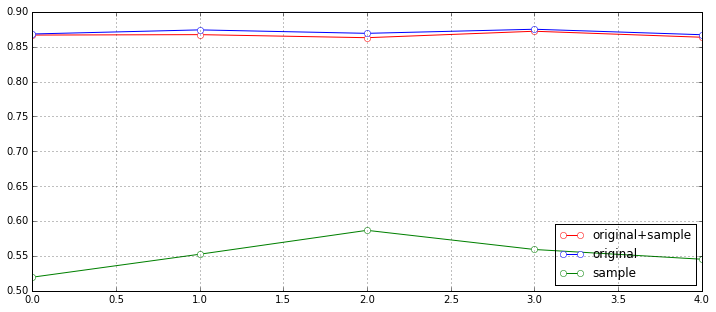

In [7]:
# draw 

# all the info is there to draw THAT
print r1,r2,r3

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.grid()
plt.plot(originals_samples, color='r', marker='o', markersize=6, markeredgecolor='r', markerfacecolor='w', label='original+sample')
plt.plot(originals, color='b', marker='o', markersize=6, markeredgecolor='b', markerfacecolor='w', label='original')
plt.plot(samples, color='g', marker='o', markersize=6, markeredgecolor='g', markerfacecolor='w', label='sample')
plt.legend(loc='lower right')
plt.savefig('plot_predictive_performance_of_samples.pdf')

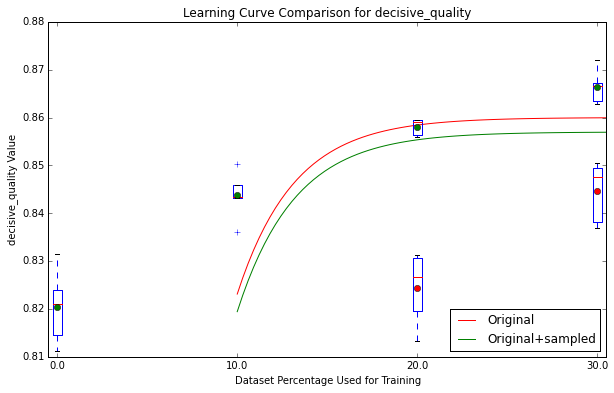

In [8]:
from graphlearn.utils.draw import draw_learning_curve
draw_learning_curve(data_A=r1,data_B=r2,x=percentages,measure='decisive_quality')

In [9]:
# looks weired oOo